# NEURAL STYLE TRANSFER ALGORITHM

In [56]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b


In [2]:
StylePath = '..input/Neural_style_transfer'
ContentPath = '..input/Neural_style_transfer'

StylePath

In [5]:
base_image_path = ContentPath+'/content.jpg'
style_image_path = StylePath+'/style.jpg'

In [6]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [7]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

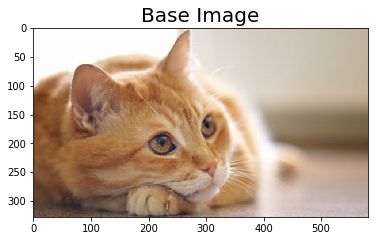

In [8]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(ContentPath+'/content.jpg')
plt.imshow(img1)

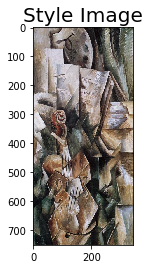

In [9]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(StylePath+'/style.jpg')
plt.imshow(img1)

In [10]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [11]:
K.image_data_format()

'channels_last'

In [12]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

W0805 13:33:07.920803  5428 deprecation_wrapper.py:119] From C:\Users\oyo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [13]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

In [17]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19
vgg19_weights = 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')


W0805 14:17:14.222124  5428 deprecation_wrapper.py:119] From C:\Users\oyo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 14:17:14.228778  5428 deprecation_wrapper.py:119] From C:\Users\oyo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 14:17:14.271579  5428 deprecation_wrapper.py:119] From C:\Users\oyo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0805 14:17:14.787364  5428 deprecation_wrapper.py:119] From C:\Users\oyo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0805 14:17:14.787364  5428 deprecation_wrapper.py:119] From C:\Users\o

Model loaded.


In [18]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [19]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

Tensor("block5_conv2/Relu:0", shape=(3, 25, 44, 512), dtype=float32)


In [20]:
#content_loss
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

In [21]:
import tensorflow as tf

def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))
    

In [26]:
content_weight=0.025 
style_weight=1.0
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss += content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl


W0805 14:17:41.722244  5428 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


Layer Feature for Content Layers :: Tensor("block5_conv2/Relu:0", shape=(3, 25, 44, 512), dtype=float32)
Base Image Feature :: Tensor("strided_slice:0", shape=(25, 44, 512), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_1:0", shape=(25, 44, 512), dtype=float32)

Layer Feature for Style Layers :: Tensor("block1_conv1/Relu:0", shape=(3, 400, 709, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_2:0", shape=(400, 709, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_3:0", shape=(400, 709, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1/Relu:0", shape=(3, 200, 354, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_6:0", shape=(200, 354, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_7:0", shape=(200, 354, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1/Relu:0", shape=(3, 100, 177, 256), 

In [27]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [28]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients/concat_grad/Slice_2:0' shape=(1, 400, 709, 3) dtype=float32>]

In [29]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

In [30]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [31]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


In [32]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [33]:
evaluator = Evaluator()

In [40]:
iterations=200
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()

Start of iteration 0
Current loss value: 2.4222445e+20
Start of iteration 1
Current loss value: 2.2555835e+20
Start of iteration 2
Current loss value: 2.0497439e+20
Start of iteration 3
Current loss value: 1.906412e+20
Start of iteration 4
Current loss value: 1.7844527e+20
Start of iteration 5
Current loss value: 1.6844075e+20
Start of iteration 6
Current loss value: 1.6018176e+20
Start of iteration 7
Current loss value: 1.534366e+20
Start of iteration 8
Current loss value: 1.4460732e+20
Start of iteration 9
Current loss value: 1.3755926e+20
Start of iteration 10
Current loss value: 1.3259667e+20
Start of iteration 11
Current loss value: 1.2826229e+20
Start of iteration 12
Current loss value: 1.2388075e+20
Start of iteration 13
Current loss value: 1.2028351e+20
Start of iteration 14
Current loss value: 1.1559191e+20
Start of iteration 15
Current loss value: 1.1141538e+20
Start of iteration 16
Current loss value: 1.0841271e+20
Start of iteration 17
Current loss value: 1.0533485e+20
Star

Current loss value: 2.1720388e+19
Start of iteration 148
Current loss value: 2.1583897e+19
Start of iteration 149
Current loss value: 2.146521e+19
Start of iteration 150
Current loss value: 2.1351733e+19
Start of iteration 151
Current loss value: 2.1256594e+19
Start of iteration 152
Current loss value: 2.1150536e+19
Start of iteration 153
Current loss value: 2.1038495e+19
Start of iteration 154
Current loss value: 2.0947693e+19
Start of iteration 155
Current loss value: 2.0857879e+19
Start of iteration 156
Current loss value: 2.0733115e+19
Start of iteration 157
Current loss value: 2.0631e+19
Start of iteration 158
Current loss value: 2.0491849e+19
Start of iteration 159
Current loss value: 2.032355e+19
Start of iteration 160
Current loss value: 2.0196001e+19
Start of iteration 161
Current loss value: 2.0081414e+19
Start of iteration 162
Current loss value: 1.996418e+19
Start of iteration 163
Current loss value: 1.9818037e+19
Start of iteration 164
Current loss value: 1.9711402e+19
Sta

**The Final Image**

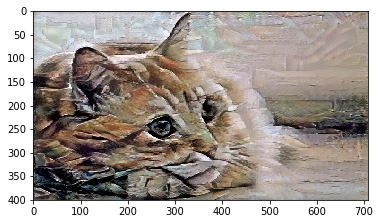

In [41]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

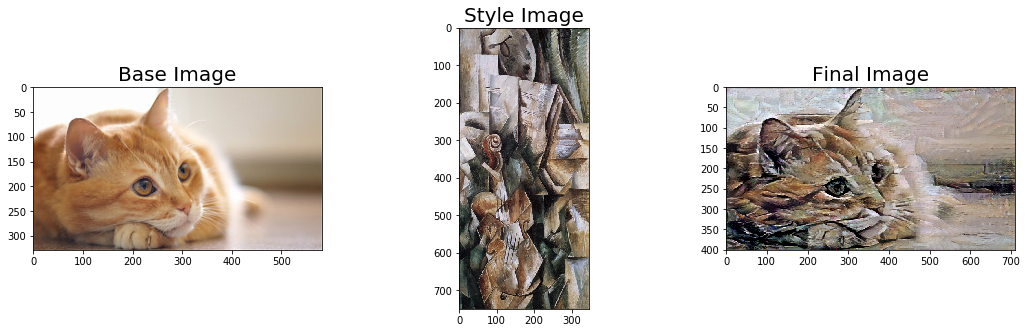

In [42]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)